# バギングと勾配ブースティングを実装する

---

## 実装してみる

### 必要なパッケージを読み込む

In [1]:
library(rpart)
library(tidyverse)
library(repr)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### バギングを実装する

サンプリングと学習を繰り返し、得られたモデル群の予測結果の平均を取る。  
平均を取ることで、バリアンスを抑え精度を向上させる。  
Random forest は決定木にバギングを適用し高精度な予測を実現した手法。

In [2]:
bagging <-
  function(train, test, model_func) {
    tibble(i = 1:20) %>%
    mutate(test.i = map(i, ~ test)) %>%
    mutate(train.i = map(i, ~ sample_n(train, 10, replace = TRUE))) %>%
    mutate(model = map(train.i, model_func)) %>%
    mutate(single = map2(model, test.i, ~ predict(.x, .y))) %>%
    mutate(ensemble = accumulate(single, ~ .x + .y)) %>%
    mutate(ensemble = map2(ensemble, i, ~ .x / .y))
  }

### 勾配ブースティング (……に似た何か) を実装する

モデルと、そのモデルの残差を予測するモデルを生成し、予測結果の和を取る。  
残差を予測するモデルの予測結果を繰り返し足すことで、残差が補正され0に近づく。  
xgboost は決定木に勾配ブースティングを適用し高精度な予測を実現した手法。

In [3]:
boosting <-
  function(train, test, model_func) {
    f <-
      function(round, round.def) {
        round$residual$y <- round$residual$y - predict(round$model, round$residual)
        model <- model_func(round$residual)
        list(model = model, residual = round$residual)
      }
    
    tibble(i = 1:20) %>%
    mutate(round = map(i, ~ list(model = model_func(train), residual = train))) %>%
    mutate(round = accumulate(round, f)) %>%
    mutate(model = map(round, ~ .$model), train.i = map(round, ~ .$residual)) %>%
    mutate(test.i = map(i, ~ test)) %>%
    mutate(single = map2(model, test.i, ~ predict(.x, .y))) %>%
    mutate(ensemble = accumulate(single, ~ .x + .y))
  }

### アンサンブルの過程を可視化する

In [4]:
gen_graph <-
  function(test, result) {
    temp.train <-
      result %>%
      select(i, train.i) %>%
      unnest(cols = c(train.i)) %>%
      mutate(type = factor("single", levels = c("single", "ensemble")))
    temp.test <-
      result %>%
      select(i, test.i, single, ensemble) %>%
      gather(key = type, value = predicted, -i, -test.i) %>%
      unnest(cols = c(test.i, predicted)) %>%
      mutate(type = factor(type, levels = c("single", "ensemble")))
    
    options(repr.plot.width = 12, repr.plot.height = 24)
    ggplot() +
    geom_line(data = test, mapping = aes(x = x, y = y)) +
    geom_line(data = temp.test, mapping = aes(x = x, y = predicted), color = "red") +
    geom_point(data = temp.train, mapping = aes(x = x, y = y), color = "red") +
    xlim(-pi, pi) +
    ylim(-2.0, 2.0) +
    facet_grid(facets = i ~ type)
  }

---

## 実際にモデルを作ってみる

### サンプルデータを生成する

In [5]:
set.seed(0)

In [6]:
train <-
  tibble(
    x = runif(n = 100, min = -pi, max = pi),
    y = sin(x) + rnorm(n = 100, mean = 0, sd = 0.2)
  )
test <-
  tibble(
    x = seq(-pi, pi, by = 0.01),
    y = sin(x)
  )

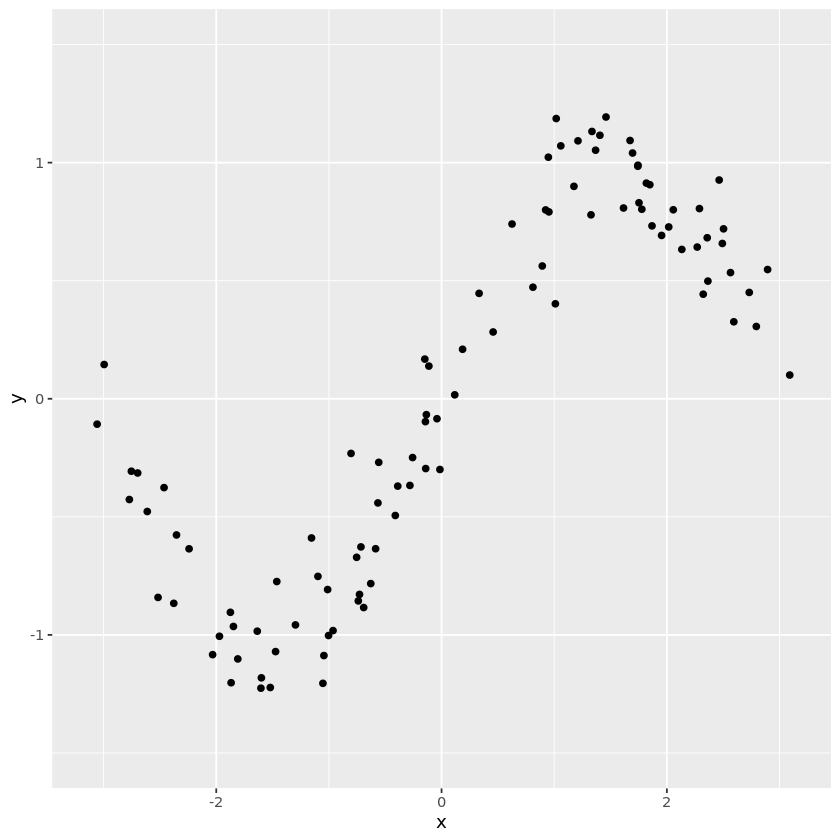

In [7]:
graph <-
  ggplot(data = train, mapping = aes(x = x, y = y)) +
  geom_point() +
  xlim(-pi, pi) +
  ylim(-1.5, 1.5)
plot(graph)

### バギング × 低バイアス高バリアンス

深さ5の複雑な決定木 (低バイアス高バリアンス) に対してバギングを適用する。  
個々のモデルはノイズに強く反応してしまっているが、平均を取ったモデルは真のモデルに近づいている。

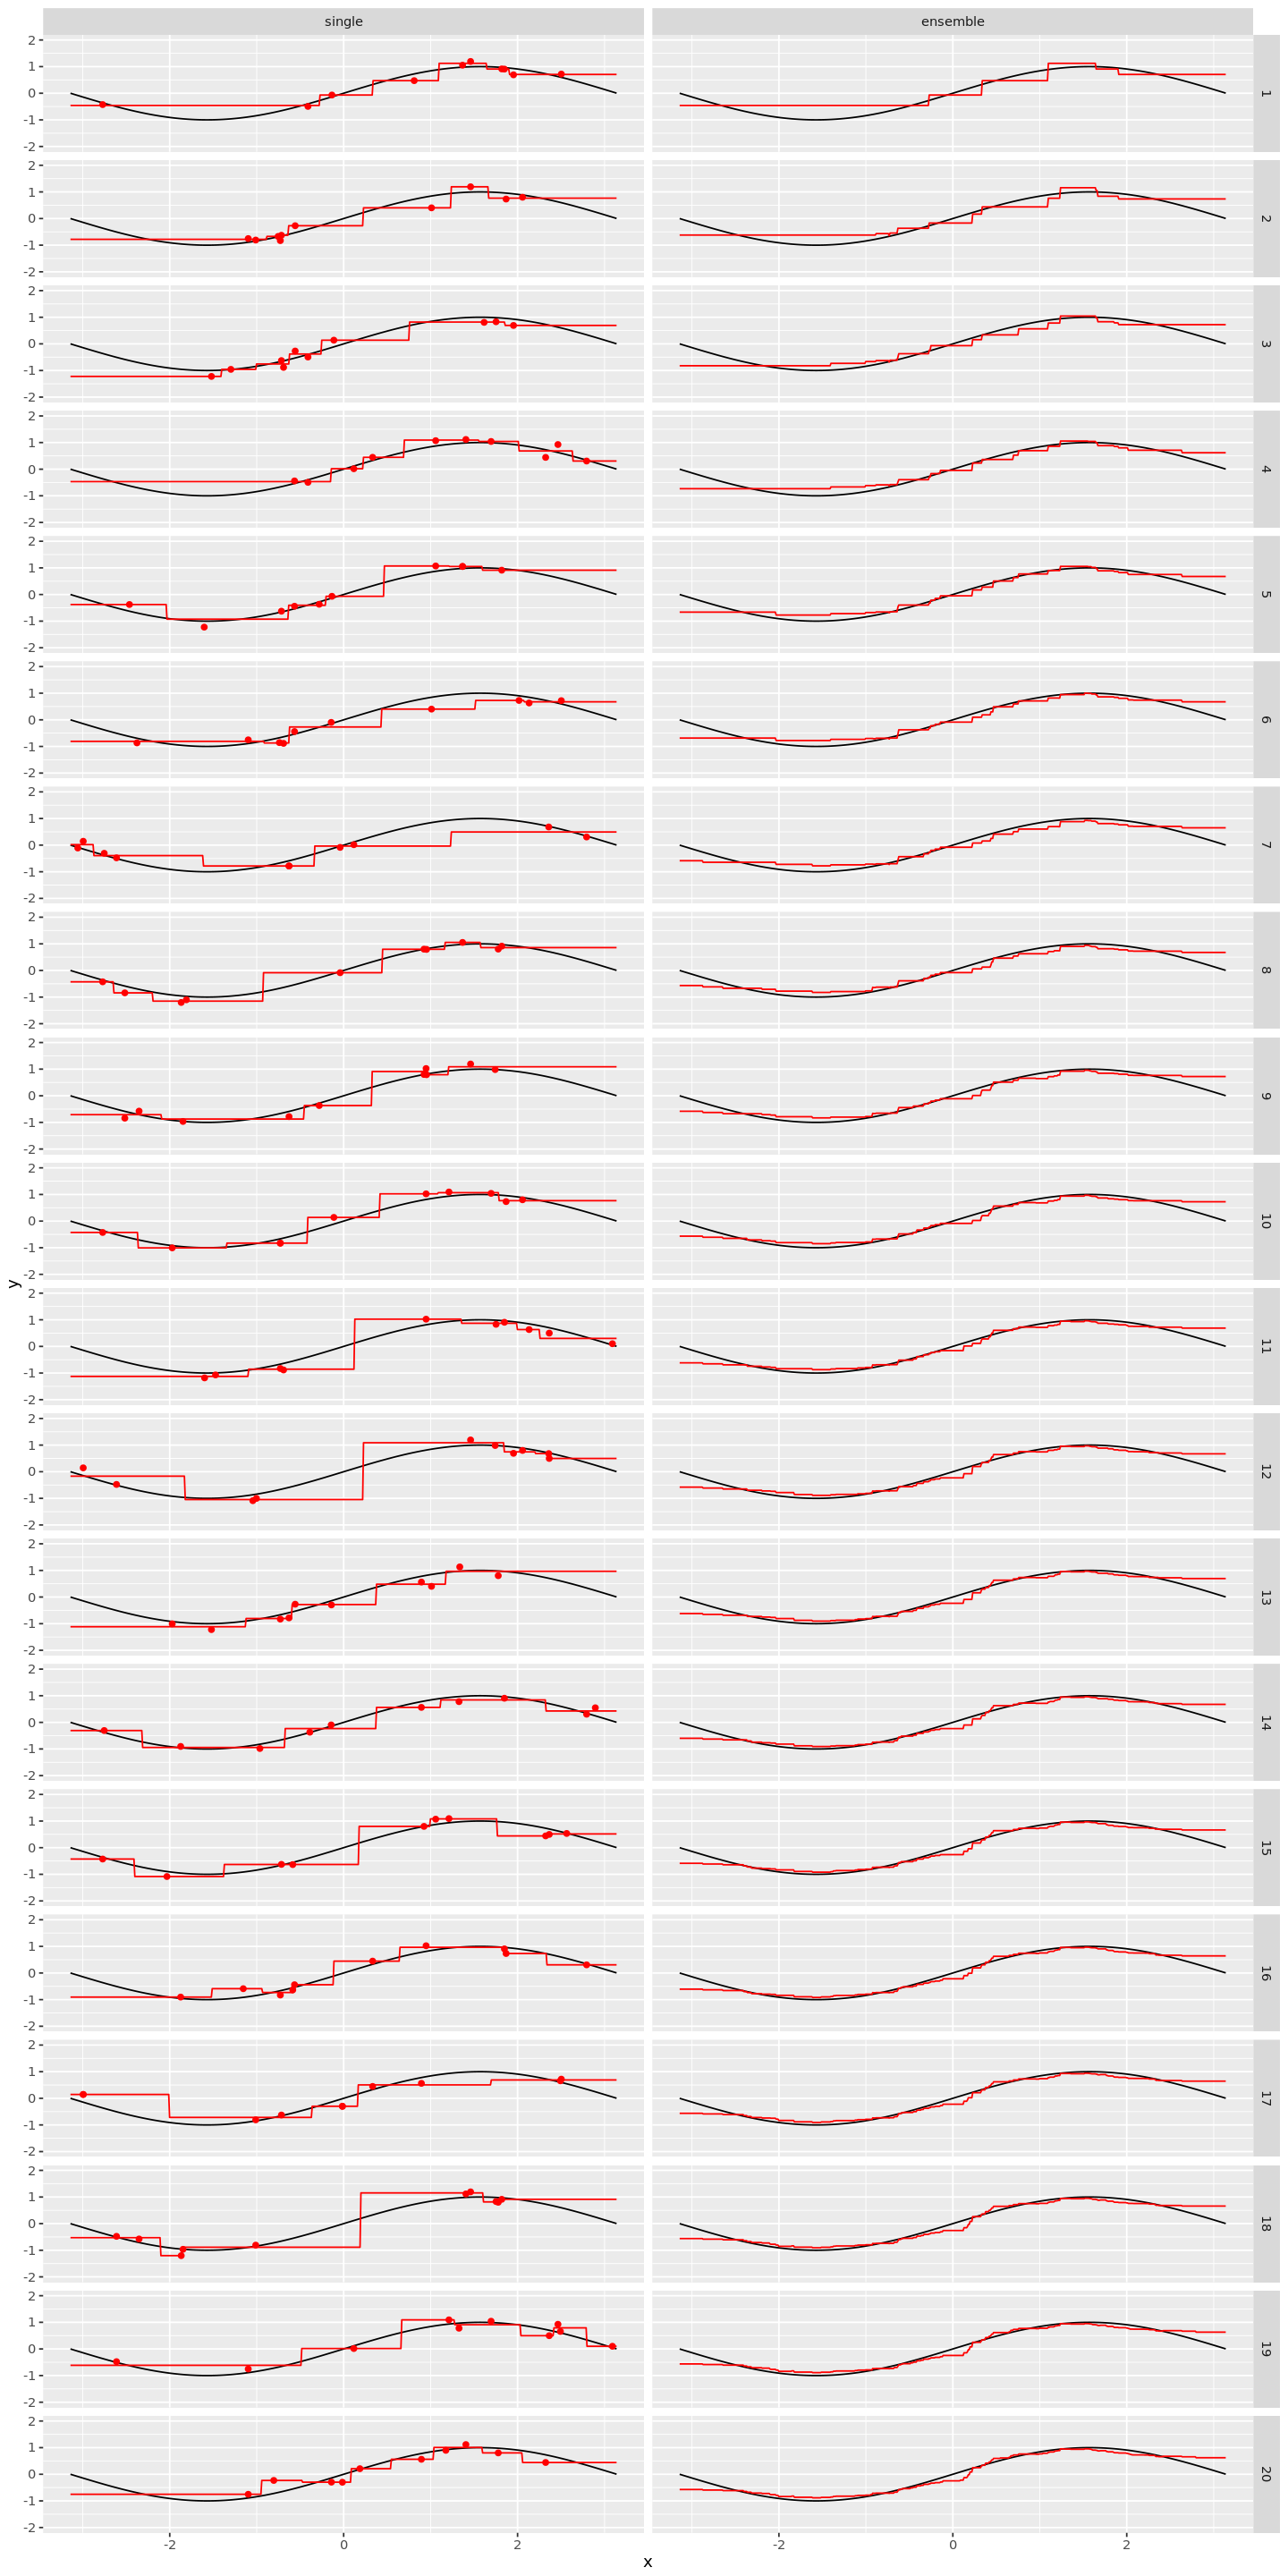

In [8]:
result <- bagging(train, test, function(data) { rpart(formula = y ~ x, data = data, maxdepth = 5, minbucket = 1, cp = 0) })
plot(gen_graph(test, result))

### バギング × 高バイアス低バリアンス

深さ1の単純な決定木 (高バイアス低バリアンス) に対してバギングを適用する。  
サンプルを変えても同じようなモデルしか生成されず、平均を取っても真のモデルには近づかない (特に両端)。

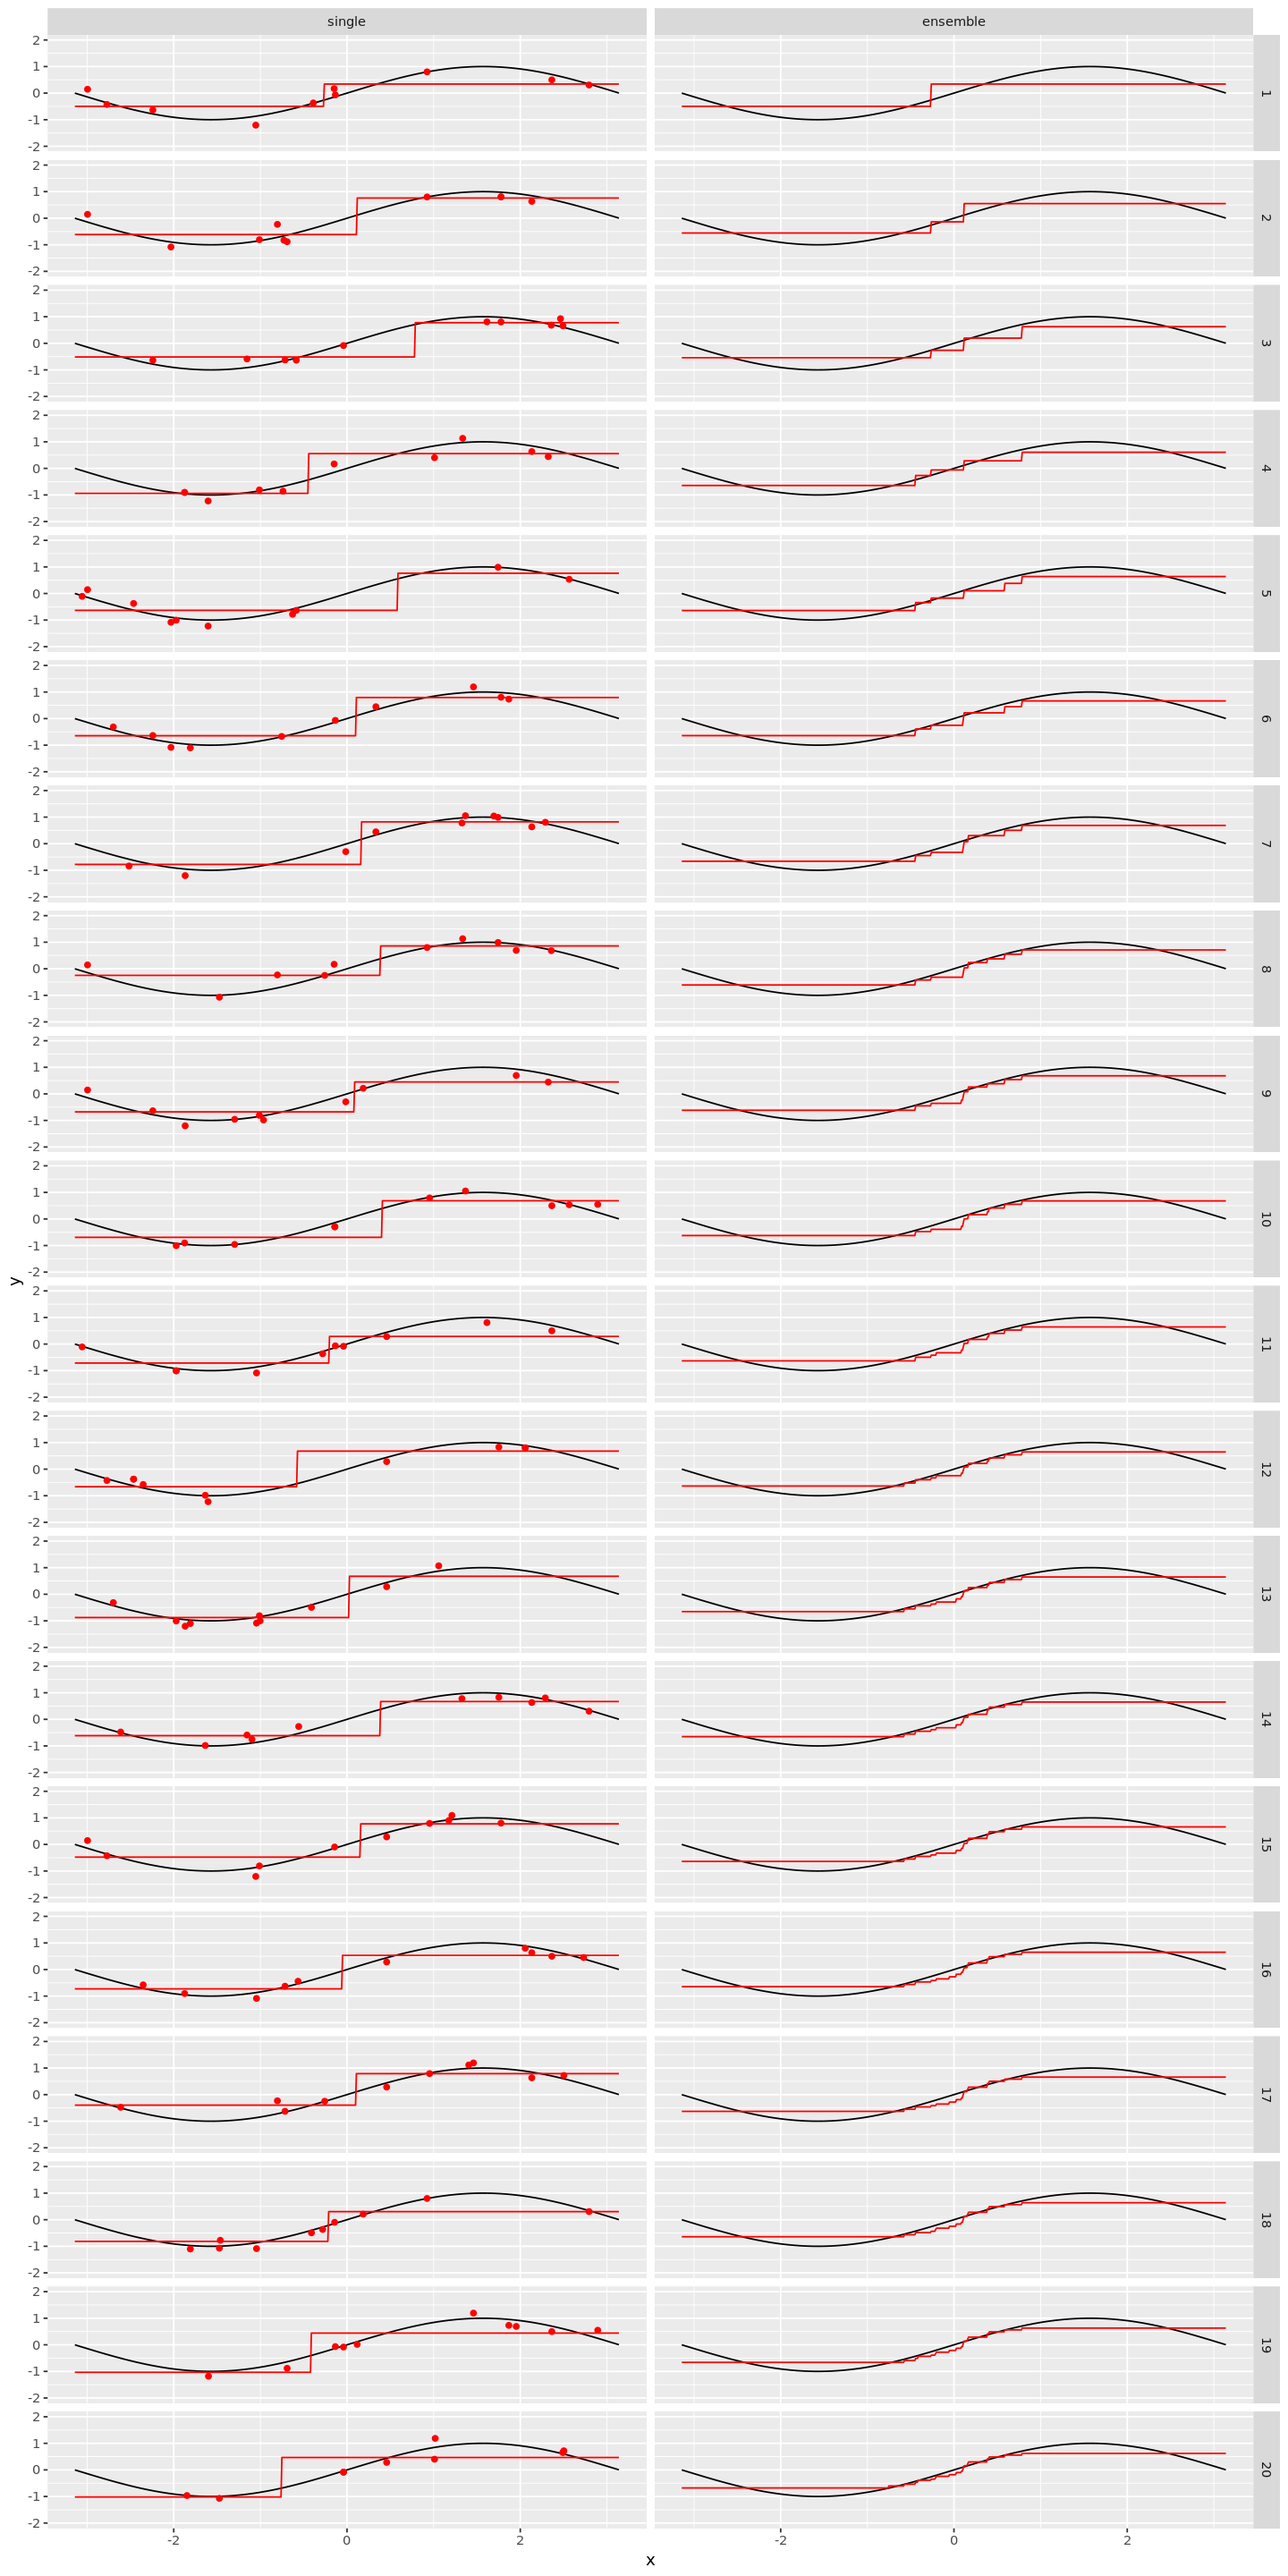

In [9]:
result <- bagging(train, test, function(data) { rpart(formula = y ~ x, data = data, maxdepth = 1, minbucket = 1, cp = 0) })
plot(gen_graph(test, result))

### 勾配ブースティング × 低バイアス高バリアンス

深さ5の複雑な決定木 (低バイアス高バリアンス) に対して勾配ブースティングを適用する。  
残差を予測するモデルを加えるほどノイズに強く反応するモデルになってしまっている。

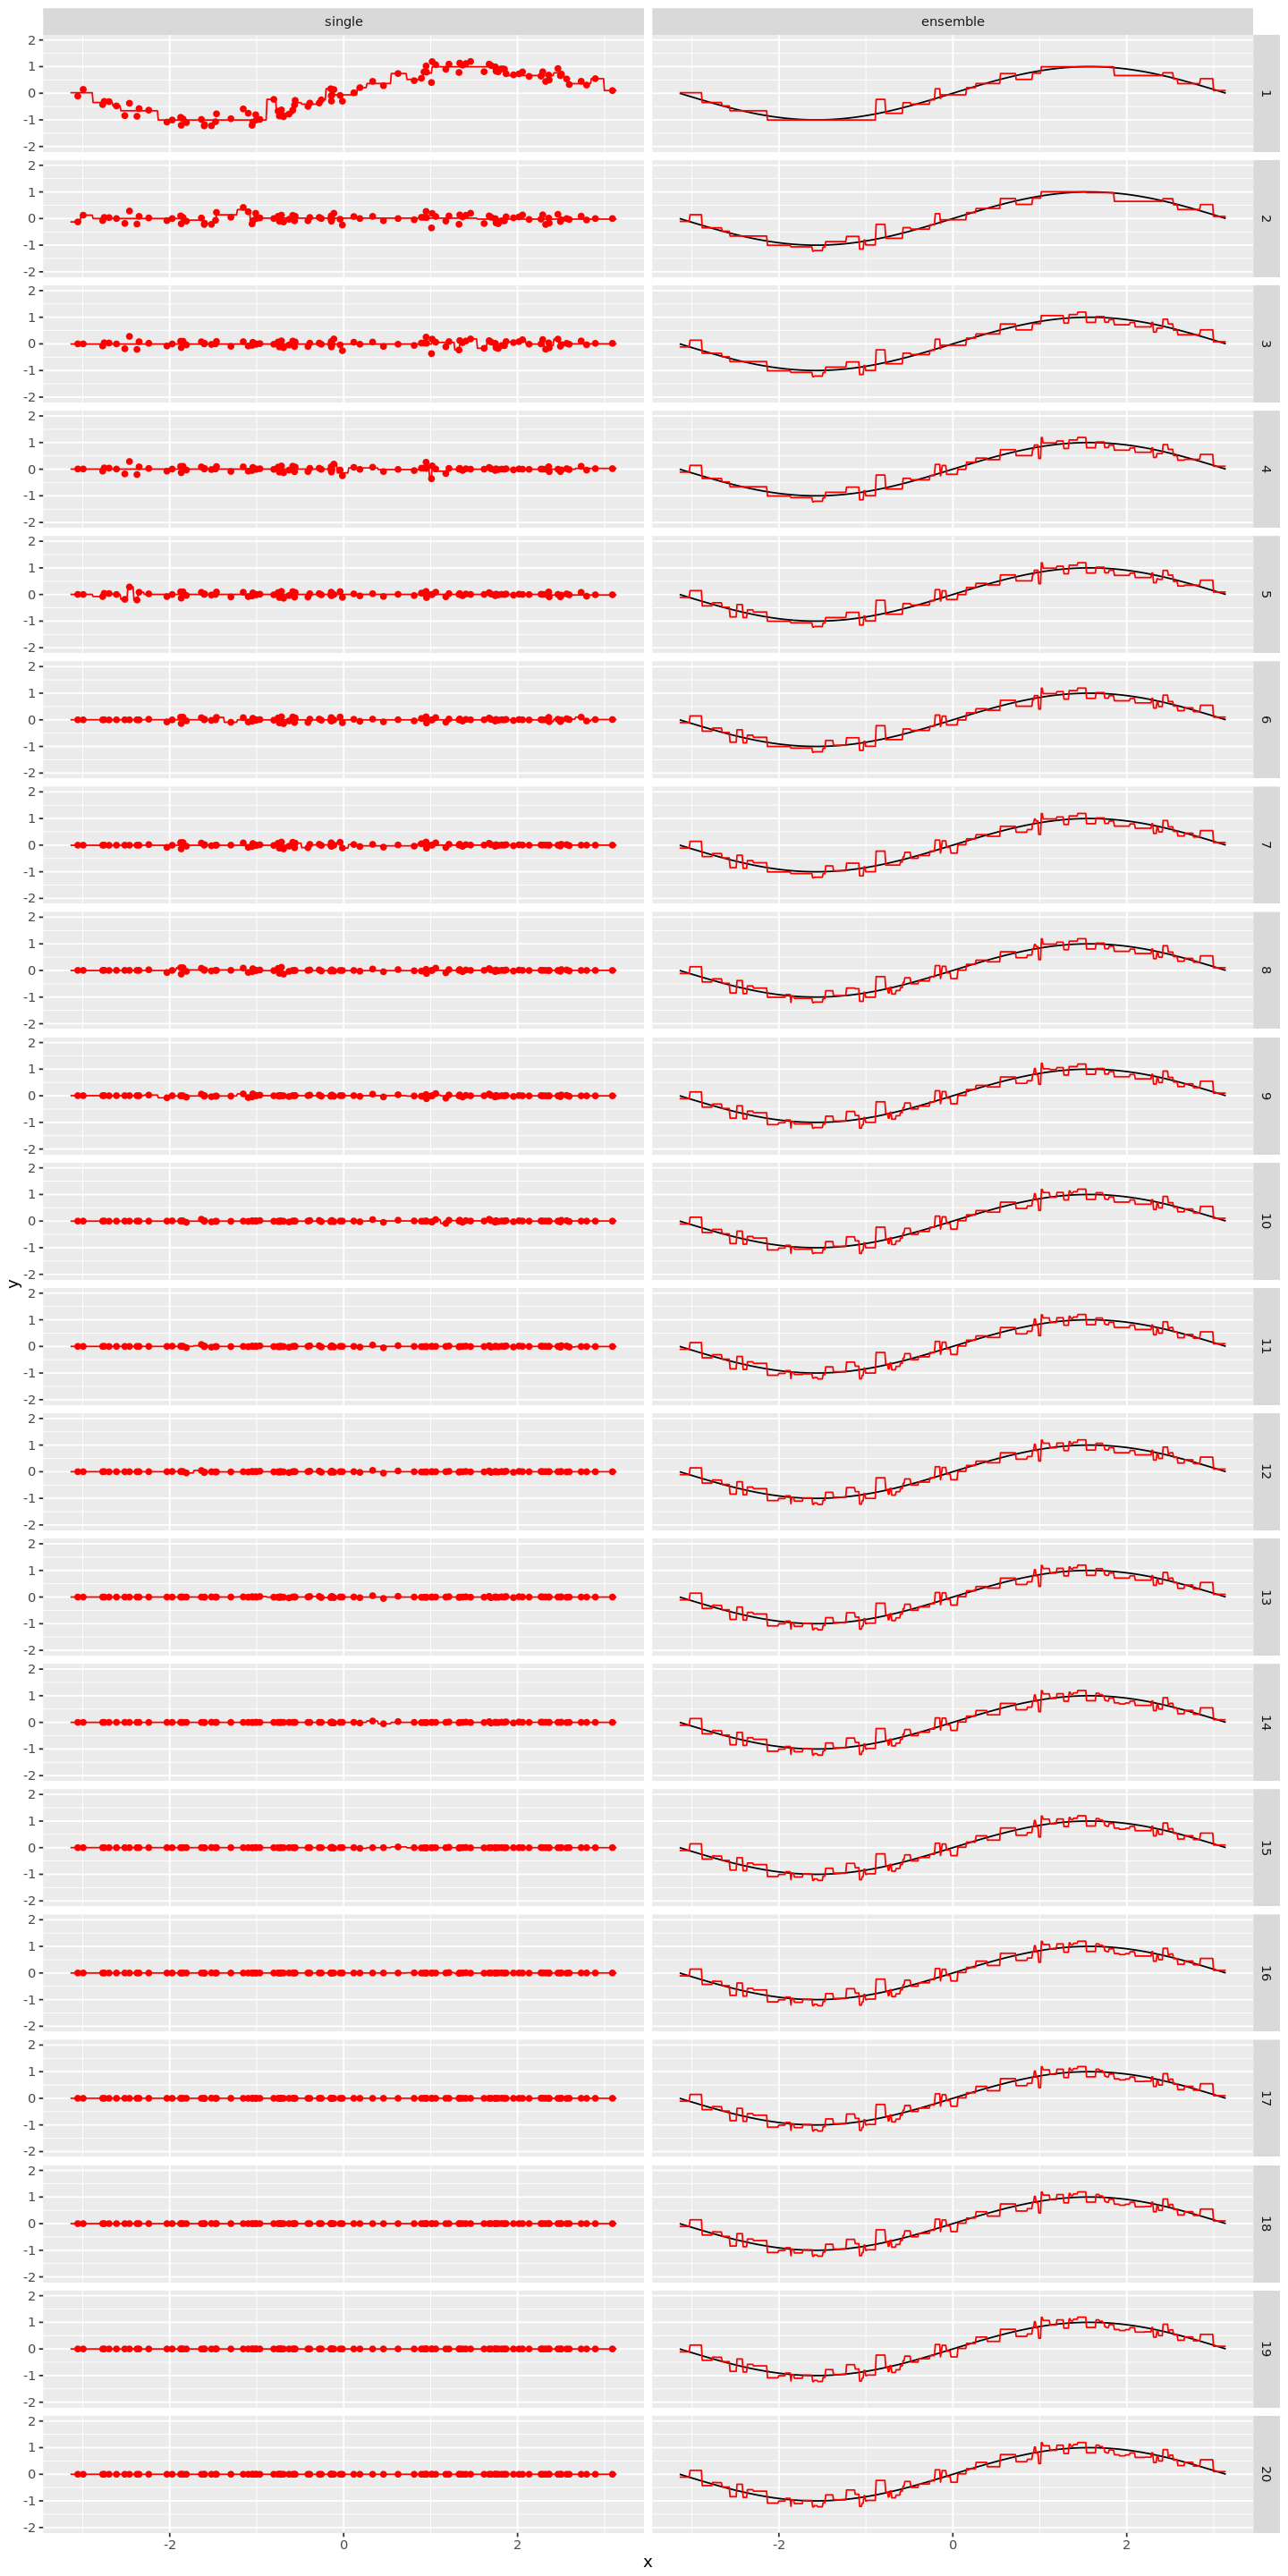

In [10]:
result <- boosting(train, test, function(data) { rpart(formula = y ~ x, data = data, maxdepth = 5, minbucket = 1, cp = 0) })
plot(gen_graph(test %>% mutate(type = factor("ensemble", levels = c("single", "ensemble"))), result))

### 勾配ブースティング × 高バイアス低バリアンス

深さ1の単純な決定木 (高バイアス低バリアンス) に対して勾配ブースティングを適用する。  
残差を予測するモデルを加えるほど真のモデルに近づいている。

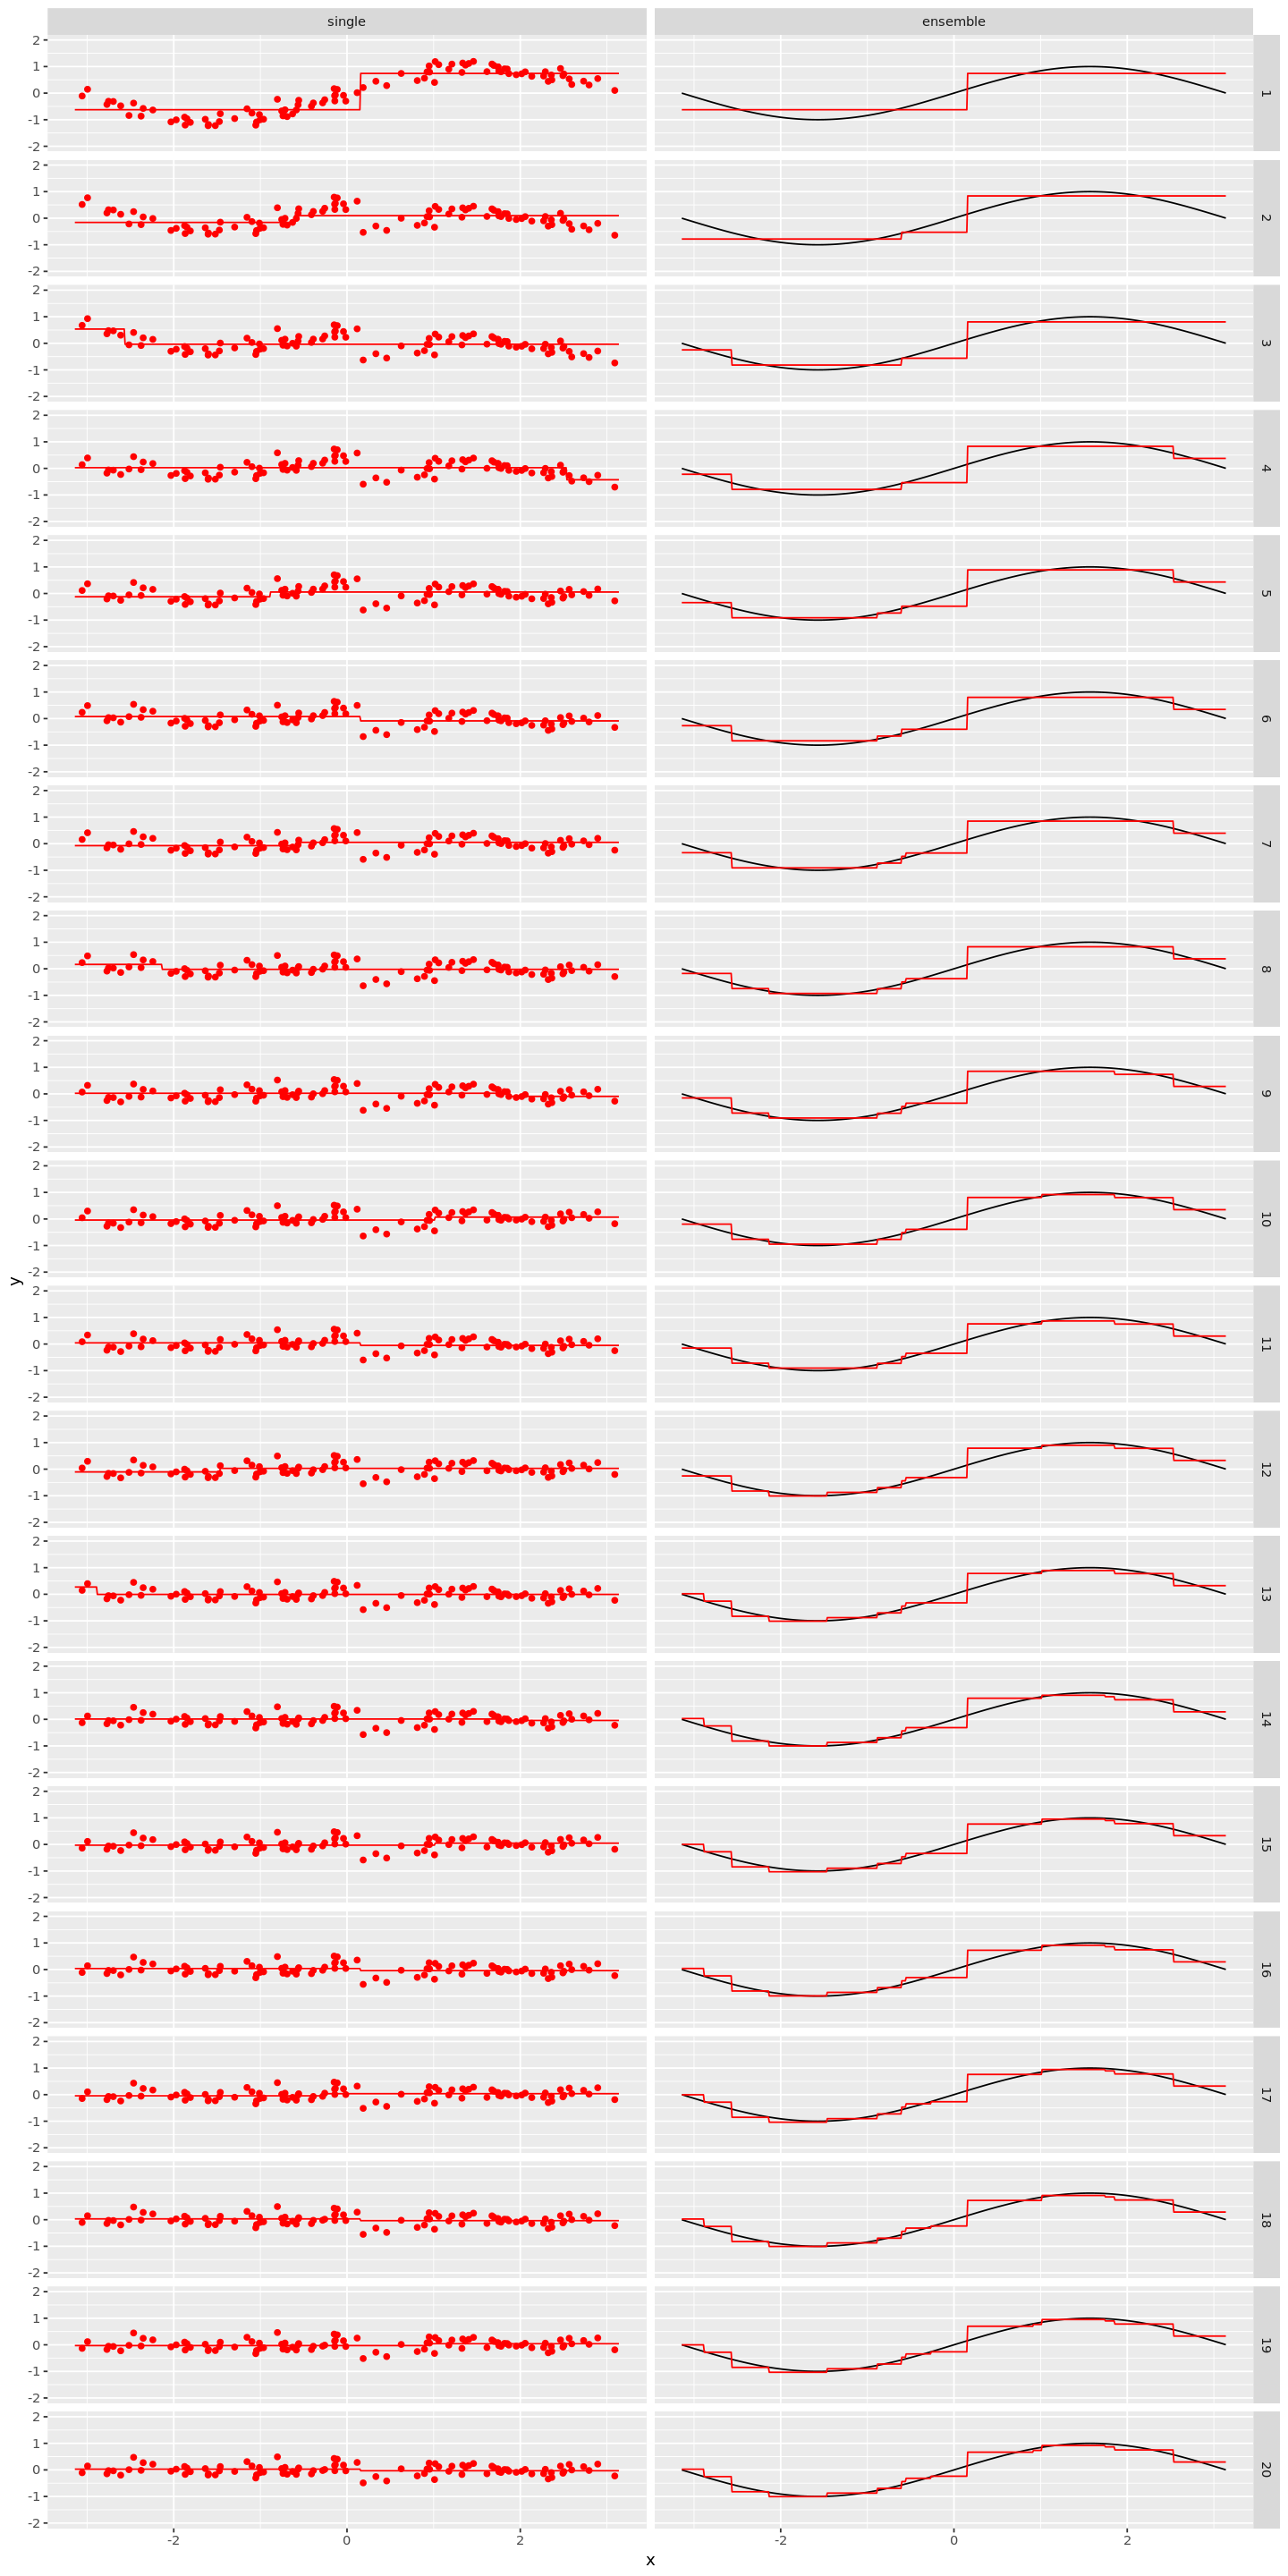

In [11]:
result <- boosting(train, test, function(data) { rpart(formula = y ~ x, data = data, maxdepth = 1, minbucket = 1, cp = 0) })
plot(gen_graph(test %>% mutate(type = factor("ensemble", levels = c("single", "ensemble"))), result))

### まとめ

* バギング
    * 平均を取ることで、ノイズを除去する (バリアンスを抑える) 効果がある。
    * そもそもノイズの乗りにくい単純なモデル (高バイアス低バリアンスなモデル) に対しては精度向上効果は薄い。
* 勾配ブースティング
    * 残差を予測するモデルを加えることで、モデルの偏りを改善する (バイアスを抑える) 効果がある。
    * そもそも偏りが生じにくい複雑なモデル (低バイアス高バリアンス) に対しては過学習が進行してしまうため逆効果？

---

## 参考文献

* [バギング - 朱鷺の杜](http://ibisforest.org/index.php?バギング)
* [Gradient Boostingについて調べたのでまとめる - St_Hakky’s blog](http://st-hakky.hatenablog.com/entry/2017/08/08/092031)
* [Greedy function approximation: a gradient boosting machine](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451)

---

## 動作環境

In [12]:
sessionInfo()

R version 3.5.2 (2018-12-20)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.8.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] repr_1.1.3      forcats_0.5.1   stringr_1.4.0   dplyr_1.0.4    
 [5] purrr_0.3.4     readr_1.4.0     tidyr_1.1.2     tibble_3.0.6   
 [9] ggplot2_3.3.3   tidyverse_1.3.0 rpart_4.1-13   

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-5      tidyselect_1.1.0  haven_2.3.1       colorspace_2.0-0 
 [5] v